### An example of my contribution to the Saturnian Spokes Research Project: <span style="color: red;"> Removing Cosmic Rays </span>


Hey there! If you're checking this out from my CV, welcome! This notebook gives a good overview of some of the work I've been doing with Dr. Douglas Hamilton on identifying spokes in Saturn's rings. It's been a really interesting challenge, and I think this is a cool example of the programming skills I've been developing.

### <span style="color: red;"> The Problem: </span> Cosmic Rays Messing with Our Spoke Images

A lot of the images we get from Cassini are riddled with what we think are cosmic rays. These are basically high-energy particles that hit the camera's sensor and create bright spots or streaks. The tricky thing is, depending on how they hit the camera, they can look like anything from tiny bright dots to long white lines.

What makes this problem even tougher compared to other astronomical image processing is that the spokes and Saturn's rings are also super bright (most times)! So, it's not as simple as just finding the brightest pixels and calling them cosmic rays. We need a way to tell the difference between real spoke features and the cosmic rays. Let's take a look at an example below to see what I mean. If you're just looking for the big picture, feel free to skim the code and just check out the markdown cells and the resulting images.


In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import spoketools as spt
import preprocess_filter as pf
import scipy.io as io
import copy 
import importlib as ib
import scipy.signal as sc
ib.reload(spt)

<module 'spoketools' from 'C:\\Users\\yugad\\gitExamples\\ResearchExample_Spokes\\spoketools.py'>

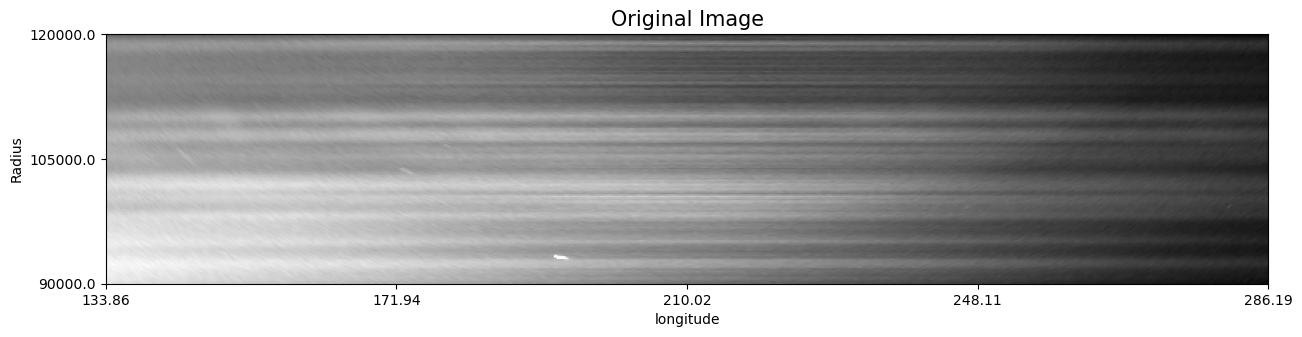

In [3]:
filename = "W1630348174_1_CALIB.rpjb"
file = io.readsav(filename) # reading the files contents for radius and longitude information

fig,ax= plt.subplots(figsize=(15,7))
_, datapoints, _ = pf.initial_crop(filename) # this function crops the file to a rectangle, and among other things, returns the cropped array. 
# we don't need the other info here (opusID, radius arrays) and hence the _
spt.label_axes(datapoints, file, ax, 'Original Image') # this function is used to label figures nicely.

This is a good example of an image heavily affected by cosmic rays. As you can see (some are highlighted below), these bright spots and streaks make it difficult to properly identify the spokes. Removing these artifacts is crucial for our analysis.

### <span align="center"> Marked image showing some of the cosmic rays </span>
<img src="MarkedImage.png">

### Previous Approach: Row-Based Bright Pixel Replacement

A previous attempt in our project addressed the cosmic ray contamination using a method similar to that described by Whitaker and Hayes et al. This approach focused on replacing the 20 brightest pixels in each row with the 21st brightest pixel in that same row. This method assumes that cosmic rays manifest as a small number of extremely bright pixels within a given row. Let's examine the results of this approach on our example image.

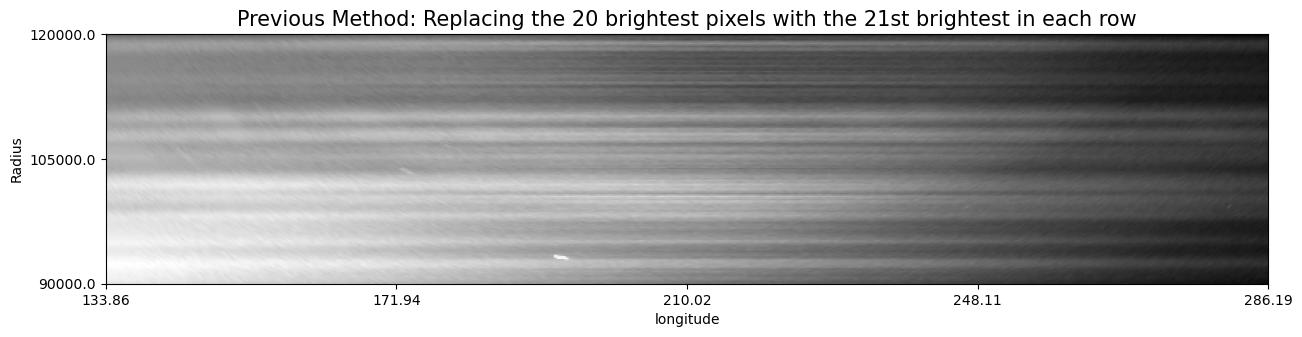

In [7]:
fig,ax= plt.subplots(figsize=(15,7))
datapointsOLD = spt.remove_cosmic_rays(datapoints) # code is in file called spoketools if you are interested. 
spt.label_axes(datapointsOLD, file, ax, 'Previous Method: Replacing the 20 brightest pixels with the 21st brightest in each row')

### Limitations of this Approach

As we can see, while this method might be effective for images with sparsely distributed, single-pixel cosmic rays, it proves insufficient for our data. For example, the large cosmic ray near the bottom-middle of the image remains largely unaffected. This is because this cosmic ray spans more than 20 pixels in a row. Replacing 20 of its pixels with a slightly less bright value has a negligible effect.

Simply increasing the number of replaced pixels is not a viable solution. The left side of the image contains regions of high brightness, comparable to the cosmic ray's intensity. Replacing, say, the 100 brightest pixels would distort these legitimate image features. While a sufficiently high replacement number *could* remove the cosmic ray, it would inevitably introduce undesirable artifacts elsewhere in the image.

This highlights the need for a more localized approach, focusing on identifying and mitigating cosmic rays based on their local characteristics rather than global row-wise statistics.

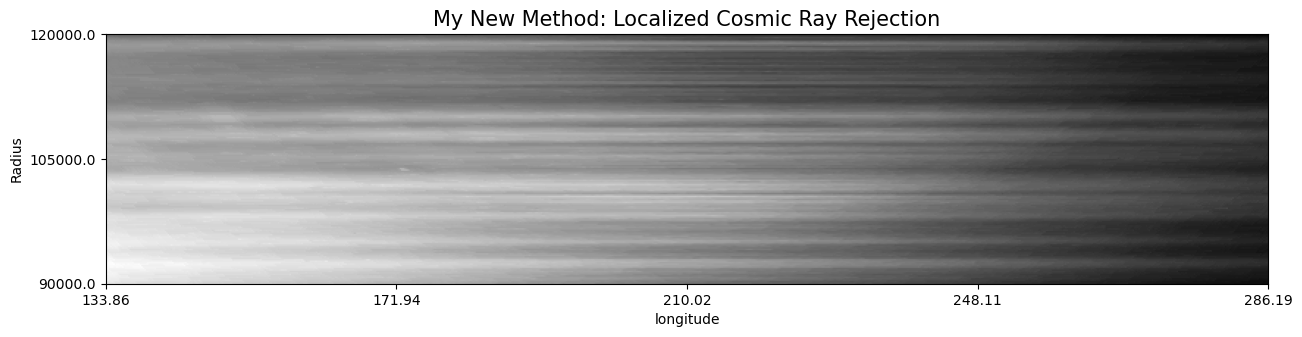

In [9]:

fig,ax= plt.subplots(figsize=(15,7))
datapointsCRR = spt.cosmic_ray_rejection(datapoints)
spt.label_axes(datapointsCRR, file, ax, 'My New Method: Localized Cosmic Ray Rejection')


### My Approach: Localized Cosmic Ray Rejection

As we can see, my approach provides a significant improvement over the previous method, and therefore better mitigating the impact of the large cosmic ray streaks. While some minor remnants may still be visible (which can be addressed by further refinements), the majority of the artifacts have been removed without significantly affecting other image features.

How did my method differ from the previous approach?


My cosmic ray rejection algorithm focuses on identifying and removing bright, narrow peaks within each row of the image. It operates in two main steps:

1.  **Peak Detection (within each row):** For each row of the image, we use the `scipy.signal.find_peaks` function to locate potential cosmic rays. This function identifies local maxima (peaks) in the row's pixel values. The `prominence` parameter is set to 0.0002. Prominence is a measure of how much a peak stands out from its surroundings. This relatively small value allows us to detect even subtle peaks that might represent cosmic rays.

2.  **Peak Width Analysis and Replacement:** Once the peaks are located, we use `scipy.signal.peak_widths` to determine the width of each peak. The `rel_height` parameter is set to 1, meaning we measure the full width at the base of the peak. The `wlen` parameter is set to 40, which is the amount of samples on each side of the peak to use to calculate the width. If a peak's width is less than 25 pixels, it's considered a likely cosmic ray. These pixels are then replaced by the mean of the pixels at the endpoints of the peak. This replacement smooths out the sharp spike caused by the cosmic ray.

This process is applied to every row in the image, effectively removing narrow, bright features that are characteristic of cosmic rays.

Here's the code implementing this algorithm:

In [12]:
def remove_outliers_in_row(row):
    '''In a single row of data, this function first finds peaks whose widths are less than 25 pixels, and replaces these pixels by the endpoints of the peaks'''
    row = row.copy()
    peaks, _ = sc.find_peaks(row, prominence=0.0002)
    results_half = sc.peak_widths(row, peaks, rel_height=1, wlen = 40)
    
    for i in range(len(results_half[0])):
        if results_half[0][i] < 25:
            row[int(results_half[2][i]):int(results_half[3][i])] = np.mean([row[int(results_half[2][i])],row[int(results_half[3][i])]])
    
    return row    

def cosmic_ray_rejection(datapoints):
    '''Applies remove_outliers_in_row to all the rows in datapoints, and returns an array removing all bright peaks that are less than 25 pixels long'''
    datapoints = copy.deepcopy(datapoints)
    rows, cols = datapoints.shape
    
    for i in range(rows):
        datapoints[i,:] = remove_outliers_in_row(datapoints[i,:])
        
    return datapoints

The advantage of this method is that it focuses on local features (the shape and width of peaks) rather than global statistics (like simply taking the brightest pixels in a row). This makes it more robust to variations in background brightness and more effective at removing cosmic rays of different intensities and sizes.

To further illustrate the algorithm's operation, let's examine a specific row from the image (Row 19), which has the bright cosmic ray in the bottom-middle section of the image.

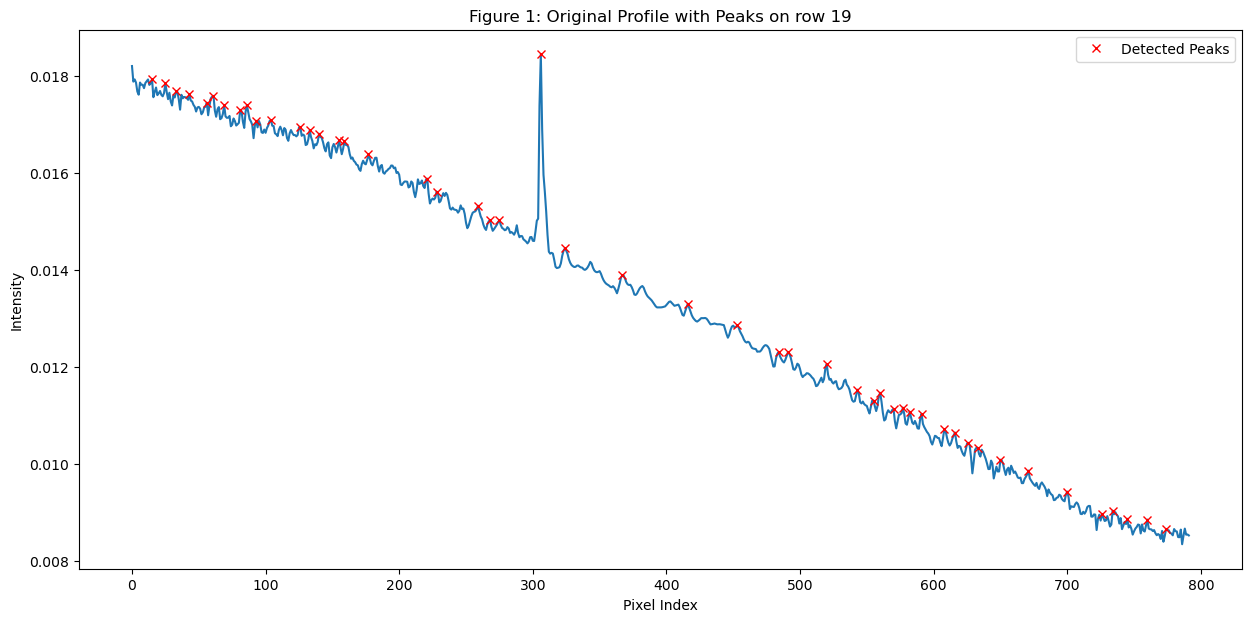

In [15]:
row = 19
rows, cols = datapoints.shape
profile = np.array(datapoints[row,:])
x = np.arange(cols)

peaks, _ = sc.find_peaks(profile, prominence=0.0002)
widths = sc.peak_widths(profile, peaks)

fig, axs = plt.subplots( figsize=(15,7))

# Plot 1: Original profile with peaks
axs.plot(x, profile)
axs.plot(peaks, profile[peaks], "x", color="red", label="Detected Peaks")
axs.set_title(f"Figure 1: Original Profile with Peaks on row {row}")
axs.set_xlabel("Pixel Index")
axs.set_ylabel("Intensity")
axs.legend()
plt.show()

**Figure 1: Original Row Profile and Detected Peaks**

This figure shows the intensity profile of Row 19. The `sc.find_peaks` function has identified several potential peaks, marked by "x" symbols.

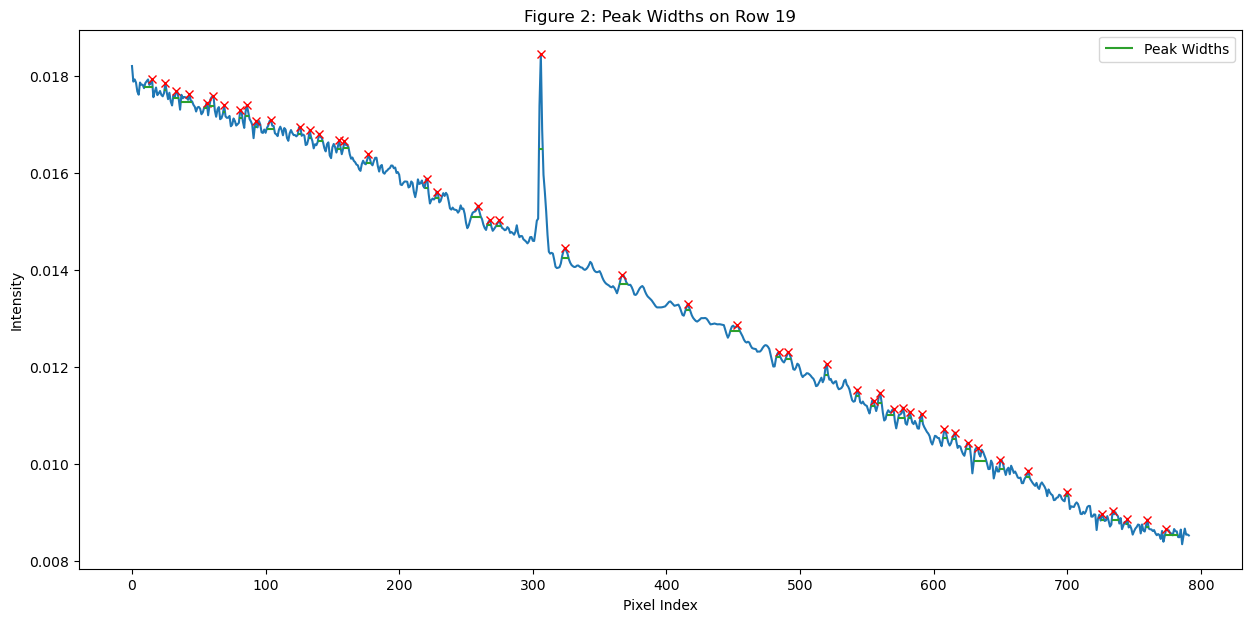

In [17]:
# Plot 2: Peak widths
fig, axs = plt.subplots( figsize=(15,7))
axs.plot(x, profile)
axs.plot(peaks, profile[peaks], "x", color="red")
axs.hlines(*widths[1:], color="C2", label="Peak Widths")
axs.set_title(f"Figure 2: Peak Widths on Row {row}")
axs.set_xlabel("Pixel Index")
axs.set_ylabel("Intensity")
axs.legend()
plt.show()

**Figure 2: Peak Widths**

In this figure, we show the same profile, but now the width of each peak is shown by a horizontal line. The algorithm then checks if the width is less than 25 pixels.

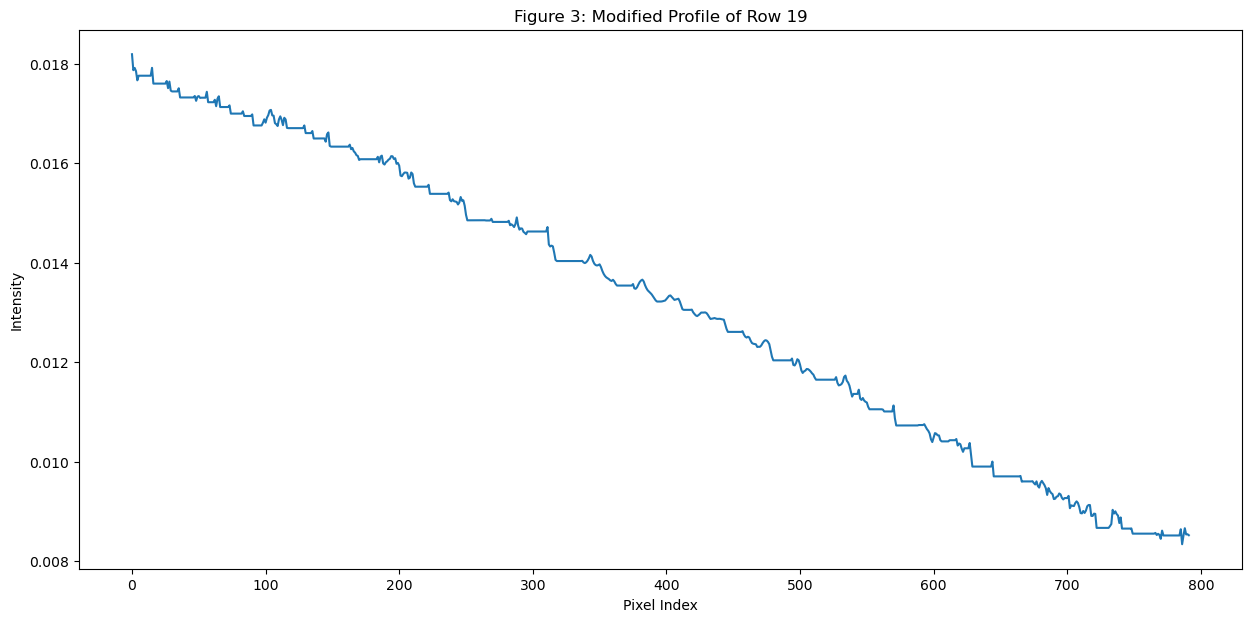

In [28]:
# Apply the cosmic ray removal
modified_profile = remove_outliers_in_row(profile)

# Plot 3: Modified profile
fig, axs = plt.subplots( figsize=(15,7))
axs.plot(x, modified_profile)
axs.set_title(f"Figure 3: Modified Profile of Row {row}")
axs.set_xlabel("Pixel Index")
axs.set_ylabel("Intensity")
plt.show()

**Figure 3: Modified Row Profile**

As you can see, the narrow peak (corresponding to the cosmic ray) has been smoothed out by replacing its pixels with the average of the endpoints. The other peaks, which have widths greater than 25 pixels, remain unchanged. This method is then applied to every row in the image to effectively remove the cosmic rays.